# ECON281-Computation Homework 8

## Jung Hyun Kim

## Compute IRF to productivity shock in Krussel-Smith (1998) economy

### **1. The Household problem and optimal policy as functions of sequence of prices**

#### *1.1 The household problem:*

\begin{align*}
V_t(e, k_{-}) &= \max_{c,k} u(c) + \beta \sum_{e'} V_{t+1} (e', k) P(e, e')
\end{align*}

subject to: 
\begin{align*}
c + k &= (1+r_t)k_{-} + w_t e n \\
k &\geq 0 \\ 
\end{align*}

#### *1.2 Optimal policy:*
$$
c_t^* (e, k_{-}) \text{ ,  } k_t^* (e, k_{-})
$$

The budget constraint implies that $\forall t$, $c_t^* (e, k_{-})$ and $k_t^* (e, k_{-})$ are functions of $\{ r_s , w_s \}_{s \geq 0}$

#### *1.3 Law of motion for the distribution of capital and productivity:*

$$
D_{t+1} (e', K) = \sum_{e} D_t (e, k_t^{*-1}(e,K)) P(e,e')
$$

where $k_t^{*-1}(e,\cdot)$ is the inverse of the optimal saving policy $k_t^*(e, \cdot)$.

Given $D_0$, the law of motion implies that $\forall t$, $D_t (e, K)$ is a function of $\{ r_s , w_s \}_{s \geq 0}$. 

(Given $D_0$, $D_1$ is a function of $k_0^{*-1}(e,K)$, which is a function of the future paths $\{ r_s , w_s \}_{s \geq 0}$, so $D_t \; \forall t\geq 1$ are also functions of $\{ r_s , w_s \}_{s \geq 0}$ through recursive dependence.)

#### *1.4 Aggregate capital is also a function of $\{ r_s , w_s \}_{s \geq 0}$:*

$$
\mathbf{A}_t (\{ r_s , w_s \}_{s \geq 0}) = \sum_e \int_{k_{-}} k_t^*(e, k_{-}) D_t(e,dk_{-})
$$

The dimensionality of the household problem reduced to the length of sequence $T$ from an infinite dimension. 

We fix aggregate labor supply: $N_t = \sum_{e} \pi(e) e n$

### **2. The firm problem**

The technology of the firm and its optimal choice of capital and labor are: 

\begin{align*}
Y_t &= Z_t K_{t-1}^\alpha N_t^{1-\alpha} \\
r_t &= \alpha Z_t K_{t-1}^{\alpha-1} N_t^{1-\alpha} - \delta \\
w_t &= (1-\alpha) Z_t K_{t-1}^{\alpha} N_t^{-\alpha}
\end{align*}


### **3. Market Clearing for capital**

$$
H_t (\mathbf{K}, \mathbf{Z}) \equiv \mathbf{A}_t (\mathbf{r}, \mathbf{w}) - K_t = 0
$$

### **4. The DAG**

The following equilibrium conditions form a DAG in one unknown $\mathbf{U} = {\mathbf{K}}$ and one target $H_t (\mathbf{K}, \mathbf{Z}) = 0$, the capital market clearing. 

1. Firm block: 
    - $Y_t = Z_t K_{t-1}^\alpha N_t^{1-\alpha}$ 
    - $r_t = \alpha Z_t K_{t-1}^{\alpha-1} N_t^{1-\alpha} - \delta$ 
    - $w_t = (1-\alpha) Z_t K_{t-1}^{\alpha} N_t^{-\alpha} $

2. Household block: 
    - $ A_t = \mathbf{A}_t (\{ r_s , w_s \}_{s \geq 0}) $

3. Market clearing for capital: 
    - $0 = \mathbf{A}_t - K_t$

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import interp1d

from blocks_jacobians import firm 

#pip install sequence-jacobian
from sequence_jacobian import grids, misc, interpolate
from sequence_jacobian.blocks.support.het_support import lottery_1d
from sequence_jacobian.utilities.solvers import newton_solver

### 0. Solve the steady state (taken from class)

In [2]:
# Variables
K = {'K'}
U = {'U'}
Y = {'A', 'Y', 'r', 'w'}

# parameters
eis = 1
delta = 0.025
alpha = 0.11
rho_e = 0.966
sd_e = 0.5
r = 0.01
Y = 1
L = 1.0
nE = 7
nA = 500
amin = 0
amax = 200
T = 100
calib = {'eis': eis, 'delta': delta, 'alpha': alpha, 'rho_e': rho_e, 'sd_e': sd_e, 'L': L, 'nE': nE, 'nA': nA, 'amin': amin, 'amax': amax}

# known steady state values
ss = {}
ss['r'] = r
ss['Y'] = Y
ss['L'] = L
ss['w'] = (1 - alpha) * ss['Y'] / ss['L']
ss['K'] = alpha * ss['Y'] / (ss['r'] + delta)
ss['A'] = ss['K']
ss['C'] = ss['Y'] - delta * ss['K']
ss['Z'] = ss['Y'] / (ss['K'] ** alpha * ss['L'] ** (1 - alpha))
ss['delta'] = delta

# grids and initial conditions
e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
a_grid = grids.agrid(amin=amin, amax=amax, n=nA)


# analytical Jacobians from firm block
J_firm = firm(calib, ss, T)

# define backward step
def backward_step(Va_p, Pi, a_grid, e_grid, r, w, beta, eis):
    uc_nextgrid = beta * (Pi @ Va_p)
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    a = interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    misc.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    return Va, a, c

# steady state solver
def solve_steady_state_policy(Va0, Pi, a_grid, e_grid, r, w, beta, eis):
    Va = Va0
    for n in range(10000):
        Va, a, c = backward_step(Va, Pi, a_grid, e_grid, r, w, beta, eis)
        if np.max(np.abs(Va - Va0)) < 1e-8:
            print(f'Converged after {n} iterations')
            break
        Va0 = Va
    return Va, a, c

# computes the transition matrix based on policy function for assets
def compute_transition_matrix(a, a_grid, e_grid, Pi):
    nE = e_grid.shape[0]
    nA = a_grid.shape[0]

    # deterministic lottery allocation
    lottery = lottery_1d(a, a_grid, monotonic=False)

    # transition matrix built from lottery
    Lambda = np.zeros((nE, nA, nE, nA))
    for i in range(nE):
        for j in range(nA):
            Lambda[i, j, :, lottery.i[i, j]] = Pi[i, :] * lottery.pi[i, j]
            Lambda[i, j, :, lottery.i[i, j] + 1] = Pi[i, :] * (1 - lottery.pi[i, j])

    # matrix form to compute transition matrix
    Lambda = Lambda.reshape(nA * nE, nA * nE)

    return Lambda

# iterates on the distribution until convergence
def compute_steady_state_distribution(a, a_grid, e_grid, Pi):

    Lambda = compute_transition_matrix(a, a_grid, e_grid, Pi)

    nE = e_grid.shape[0]
    nA = a_grid.shape[0]

    D = np.ones(nE * nA) / (nE * nA)
    for n in range(10000):
        D = Lambda.T @ D
        if np.max(np.abs(D - D @ Lambda)) < 1e-8:
            D = D.reshape(nE, nA)
            print(f'Converged after {n} iterations')
            break
    return D, Lambda


In [3]:
# solve for beta such that asset demand is at steady state
coh = (1 + r) * a_grid[np.newaxis, :] + ss['w'] * e_grid[:, np.newaxis]
Va0 = (1 + r) * (0.1 * coh) ** (-1 / eis)

beta = 0.981
Va, a, c = solve_steady_state_policy(Va0, Pi, a_grid, e_grid, ss['r'], ss['w'], beta, eis)
D, Lambda = compute_steady_state_distribution(a, a_grid, e_grid, Pi)

# find beta that solves the market clearing problem in steady state
def objective(beta):
    Va, a, c = solve_steady_state_policy(Va0, Pi, a_grid, e_grid, ss['r'], ss['w'], beta, eis)
    D, Lambda = compute_steady_state_distribution(a, a_grid, e_grid, Pi)
    A = np.sum(D @ a_grid)
    return np.array([A - ss['A']])

beta, feval = newton_solver(objective, np.array([beta]))

print(beta)

calib['beta'] = beta

Va, a, c = solve_steady_state_policy(Va0, Pi, a_grid, e_grid, ss['r'], ss['w'], calib['beta'], eis)
D, Lambda = compute_steady_state_distribution(a, a_grid, e_grid, Pi)

ss['Va'] = Va
ss['a'] = a
ss['c'] = c
ss['D'] = D
ss['Lambda'] = Lambda


Converged after 361 iterations
Converged after 513 iterations
Converged after 361 iterations
Converged after 513 iterations
On iteration 0
x = 0.981
y = -0.554


Converged after 362 iterations
Converged after 513 iterations
Converged after 391 iterations
Converged after 568 iterations
On iteration 1
x = 0.982
y = 0.080


Converged after 391 iterations
Converged after 569 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 2
x = 0.982
y = 0.001


Converged after 388 iterations
Converged after 562 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 3
x = 0.982
y = 0.000


Converged after 388 iterations
Converged after 562 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 4
x = 0.982
y = 0.000


Converged after 388 iterations
Converged after 562 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 5
x = 0.982
y = 0.000


[0.98195277]
Converged after 387 

### **Computing Jacobians for hetero-agent problems using Fake News Algorithm**

Assume $\exist$ functions $\nu$, $\Lambda$, and $y$ such that, given $\mathbf{D}_0$, $\mathbf{Y}_t$ is the solution to the following system of equations: 
\begin{align*}
\mathbf{v}_t &= \nu(\mathbf{v}_{t+1}, \mathbf{X}_t) \\
\mathbf{D}_{t+1} &= \Lambda(\mathbf{v}_{t+1}, \mathbf{X}_t)' \mathbf{D}_t \\
\mathbf{Y}_t &= y(\mathbf{v}_{t+1}, \mathbf{X}_t)' \mathbf{D}_t
\end{align*}

The generic representation of a heterogeneous agent problem is a mapping from aggregate inputs $\{ \mathbf{X}_t \}$ to aggregate outputs $\{ \mathbf{Y}_t \}$: $\mathbf{Y} = h(\mathbf{X})$. 

The fake news algorithm will be used to compute the Jacobian $\mathcal{J}$ of $h$ evaluated at $\mathbf{X} = \mathbf{X}_{ss}$, which is the aggregate response of heterogeneous agents to perturbations. 

### 1. Compute Backward Step Once

- Consider transitions of length T (from date 0 to T-1). Date T is the terminal condition, during which the economy is at the stationary equilibrium. We set $T=100$
- Calculate $y_0^s$ (asset policy) and $\Lambda_0^s$ (transition matrix between states at time $0$ given shock at time $s$) for each $s$ using single backward iteration from time $T-1$. 
- Lemma 1 of Auclert et al (2021): individual policy function and transition matrix depends on the distance to the shocks
- Only single perturbation of input at date $s=T-1=99$ suffices to get $y_t^s$ and $\Lambda_t^s$

In [4]:
# Define r sequence 
dx = 1e-4
dA_seq = np.zeros(T,)
dr_seq = np.zeros(T + 1,) # dr_seq includes the terminal condition at date T=100
dr_seq[T-1] = dx # shock at time 99

# Solve backward step starting at T + 1
Va_p = ss['Va']
a_seq = np.zeros((nE, nA, T + 1)) 
c_seq = np.zeros((nE, nA, T + 1)) 

for t in reversed(range(T + 1)): 
    Va_p, a_seq[:, :, t], c_seq[:,:,t] = backward_step(Va_p, Pi, a_grid, e_grid, ss['r'] + dr_seq[t], ss['w'], calib['beta'], eis)
    

### 2. Compute the first row of the Jacobian / Fake News Matrix (FNM)

Define the difference between time-t response of time-s shock and time-(t-1) response of time-(s-1) shock as: 

$$
\mathcal{F}_{t,s} \cdot dx \equiv dY_t^s - dY_{t-1}^{s-1}
$$

By Lemma 2 of Auclert et al. (2021), when $\mathbf{D}_0 = \mathbf{D}_{ss}$ we have: 
$$
\mathcal{F}_{t,s} \cdot dx = \mathbf{y'}_{ss} (\Lambda^{'}_{ss})^{t-1} d\mathbf{D}_1^s
$$

Lemma 2 implies that $\mathcal{F}_{t,s}$ can be interpreted as the time-t impulse response to time-s fake news shock. 

Using the expectation vector $\mathcal{E} \equiv (\Lambda_{ss}^t) \mathbf{y}_{ss}$, the FNM $\mathcal{F}$ can be re-defined as: 
$$
\mathcal{F}_{t,s} \cdot dx \equiv
\begin{cases}
dY_0^s & t = 0 \\
\mathcal{E}'_{t-1} d\mathbf{D}_1^s & t \geq 1
\end{cases} \\~\\

\text{where } dY_0^s = (dy_0^s) D_{ss} \text{ and } d\mathbf{D}_1^s = (d\mathbf{\Lambda}_0^s)' D_{ss}.
$$

- Each column of the first row of the Fake News Matrix $dY_0^s / dx$ represents time 0 response to the fake news shock at time $s$
- $dY_0^s = (d \mathbf{y}_0^s)'\mathbf{D}_{ss}$ represents the effect on the output $Y_0^s$ (Aggregate asset demand) from the shock to the input ($r$) at date $s$
- By symmetry of the policy function with respect to time, we have $\mathbf{y}_0^s = \mathbf{y}_{T-1-s}^{T-1} $

In [5]:
# Initialize FNM
F = np.zeros((T, T))
da = a_seq - ss['a'][:, :, np.newaxis] # Change in asset policy given shock at T-1 = 99 

# Compute first row of FNM
for s in range(T): 
    # response at time 0 to shock at time s = response of shock at time T-1-s to shock at T-1=99 
    F[0, s] = np.vdot(ss['D'], da[:,:,T-1-s]) / dx 


### 3. Compute $dD_1^s$ using steady state distribution and $s=0,...,T$ policy functions

- $d\mathbf{D}_1^s = (d\mathbf{\Lambda}_0^s)' D_{ss}$ is the response of the distribution at date 0 to shock at time $s$
- By symmetry of the transition matrix with respect to time, we have $\Lambda_0^s = \Lambda_{T-1-s}^{T-1}$

In [6]:
# Initialize dD1 
dD1 = np.zeros((nE, nA, T), dtype=np.float32)

# Compute dD1
for s in range(T):
    dLambda0 = compute_transition_matrix(a_seq[:,:,T-1-s], a_grid, e_grid, Pi) - ss['Lambda']
    dD1[:,:,s] =  (dLambda0.T @ ss['D'].ravel()).reshape(nE, nA)


### 4. Compose the fake news matrix

The FNM $\mathcal{F}$ is defined as: 
$$
\mathcal{F}_{t,s} \cdot dx \equiv
\begin{cases}
dY_0^s & t = 0 \\
\mathcal{E}'_{t-1} d\mathbf{D}_1^s & t \geq 1
\end{cases} \\~\\

\text{where } dY_0^s = (dy_0^s) D_{ss} \text{ and } d\mathbf{D}_1^s = (d\mathbf{\Lambda}_0^s)' D_{ss}.
$$

We have calculated $dY_0^s$ and $d\mathbf{D}_1^s$ above. Now we need to calculate the expectation vector. 

The expectation vector for outcome $Y$ at time $t$ is defined as: 
$$
\mathcal{E}_t \equiv (\Lambda_{ss})^t \mathbf{y}_{ss}
$$
- Note: $D_t^{s} = (\Lambda^{'}_{ss})^t D_0^{s}$ represents the distribution $t$ periods from now, assuming that agents behave optimally
- $\mathcal{E}_t$ represents the expected time path for outcome $Y$ in the steady state for a given grid point
- By Lemma 3 of Auclert et al. (2021), $\mathcal{E}_t = \Lambda_{ss} \mathcal{E}_{t-1}$ with $\mathcal{E}_0 = \mathbf{y}_{ss}$


In [7]:
# Construct expectation vector
expvec = np.zeros((nE, nA, T))
expvec[:,:,0] = ss['a']
for t in range(1,T): 
    expvec[:,:,t] = (ss['Lambda'] @ expvec[:,:,t-1].ravel()).reshape(nE, nA)

# Construct the FNM along the row
F[1:T,:] = expvec[:,:,0:T-1].reshape(nE*nA,T-1).T @ dD1.reshape(nE*nA, T) / dx

### 5. Compose the Jacobian (with respect to interest rate and wage) using the fake news matrix

In [8]:
J_HA = {}

J_HA['A'] = {'r': F.copy()}

for t in range(1, F.shape[0]):
    J_HA['A']['r'][1:, t] += J_HA['A']['r'][:-1, t-1]


In [9]:
# Same prodecure for wage

# Define w sequence 
dA_seq = np.zeros(T,)
dw_seq = np.zeros(T + 1,) # dr_seq includes the terminal condition at date T=100
dw_seq[T-1] = dx # shock at time 99

# Solve backward step starting at T + 1
Va_p = ss['Va']
a_seq = np.zeros((nE, nA, T + 1)) # includes terminal condition at date T=100
c_seq = np.zeros((nE, nA, T + 1)) # includes terminal condition at date T=100

for t in reversed(range(T + 1)): # start from terminal condition to date 0
    Va_p, a_seq[:, :, t], c_seq[:,:,t] = backward_step(Va_p, Pi, a_grid, e_grid, ss['r'], ss['w'] + dw_seq[t], calib['beta'], eis)


# Initialize FNM
Fw = np.zeros((T,T))
da = a_seq - ss['a'][:, :, np.newaxis] # Change in asset policy given shock at T-1 = 99 
dD1 = np.zeros((nE, nA, T), dtype=np.float32)

for s in range(T): # shock at time 0 to 99
    Fw[0, s] = np.vdot(ss['D'], da[:,:,T-1-s]) / dx # response at time 0 to shock at time s = response of shock at time T-1-s to shock at T-1=99 
    dLambda0 = compute_transition_matrix(a_seq[:,:,T-1-s], a_grid, e_grid, Pi) - ss['Lambda']
    dD1[:,:,s] =  (dLambda0.T @ ss['D'].ravel()).reshape(nE, nA)

# Construct expectation vector
expvec = np.zeros((nE, nA, T))
expvec[:,:,0] = ss['a']
for t in range(1,T): 
    expvec[:,:,t] = (ss['Lambda'] @ expvec[:,:,t-1].ravel()).reshape(nE, nA)

# Construct the FNM along the row
Fw[1:T,:] = expvec[:,:,0:T-1].reshape(nE*nA,T-1).T @ dD1.reshape(nE*nA, T) / dx

J_HA['A']['w'] = Fw.copy()

for t in range(1, Fw.shape[0]):
    J_HA['A']['w'][1:, t] += J_HA['A']['w'][:-1, t-1]



### 6. Combine matrices to get $H_K$ and $H_Z$

In [10]:
I = sp.sparse.eye(T)
Ip1 = sp.sparse.diags([np.ones(T-1)], [1], (T, T))
Im1 = sp.sparse.diags([np.ones(T-1)], [-1], (T, T))
Z = sp.sparse.csr_matrix((T, T))

# Target: Asset market clearing block
PhiAM_Y = Z
PhiAM_r = Z
PhiAM_w = Z
PhiAM_A = I 
PhiAM_k = I

dHdY = sp.sparse.bmat([[PhiAM_Y, PhiAM_r, PhiAM_w, PhiAM_A]])

# Construct firm block matrics: dYFdK and dYFdZ
dYFdK = sp.sparse.bmat([[J_firm['Y']['K']],
                        [J_firm['r']['K']], 
                        [J_firm['w']['K']]])

dYFdZ = sp.sparse.bmat([[J_firm['Y']['Z']],
                        [J_firm['r']['Z']], 
                        [J_firm['w']['Z']]])
                       
# Construct household block matrics: dYHAdK and dYHAdZ
dYHAdK = J_HA['A']['r'] @ J_firm['r']['K'] + J_HA['A']['w'] @ J_firm['w']['K']
dYHAdZ = J_HA['A']['r'] @ J_firm['r']['Z'] + J_HA['A']['w'] @ J_firm['w']['Z']

# Stack block matrices
dYdK = sp.sparse.bmat([[dYFdK],
                       [dYHAdK]])

dYdZ = sp.sparse.bmat([[dYFdZ], 
                       [dYHAdZ]])

# Get dHdK and dHdZ
dHdK = dHdY @ dYdK - PhiAM_k
dHdZ = dHdY @ dYdZ 

# Compute Jacobian of the model
dKdZ = - sp.sparse.linalg.spsolve(dHdK, dHdZ)
dYdZ = dYdK @ dKdZ + dYdZ 

dXdZ = sp.sparse.bmat([[dKdZ],
                       [dYdZ]])



d:\Anaconda\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:395: SparseEfficiencyWarning: splu converted its input to CSC format
d:\Anaconda\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format


In [11]:
# AR(1) shock at t=0 and t=10
rho = 0.9

z0 = np.zeros(T)
z10 = np.zeros(T)

z0[0] = 1
z10[10] = 1

for i in range(1, T):
    z0[i] = rho * z0[i-1] 

for i in range(11, T): 
    z10[i] = rho * z10[i-1]


# Unpack Y, r, w, A and K

X0 = dXdZ @ z0 
X10 = dXdZ @ z10 

K0 = X0[0:T]
Y0 = X0[T:2*T]
r0 = X0[2*T:3*T]
w0 = X0[3*T:4*T]
A0 = X0[4*T:5*T]

assert np.allclose(K0, A0)

K10 = X10[0:T]
Y10 = X10[T:2*T]
r10 = X10[2*T:3*T]
w10 = X10[3*T:4*T]
A10 = X10[4*T:5*T]

assert np.allclose(K10, A10)



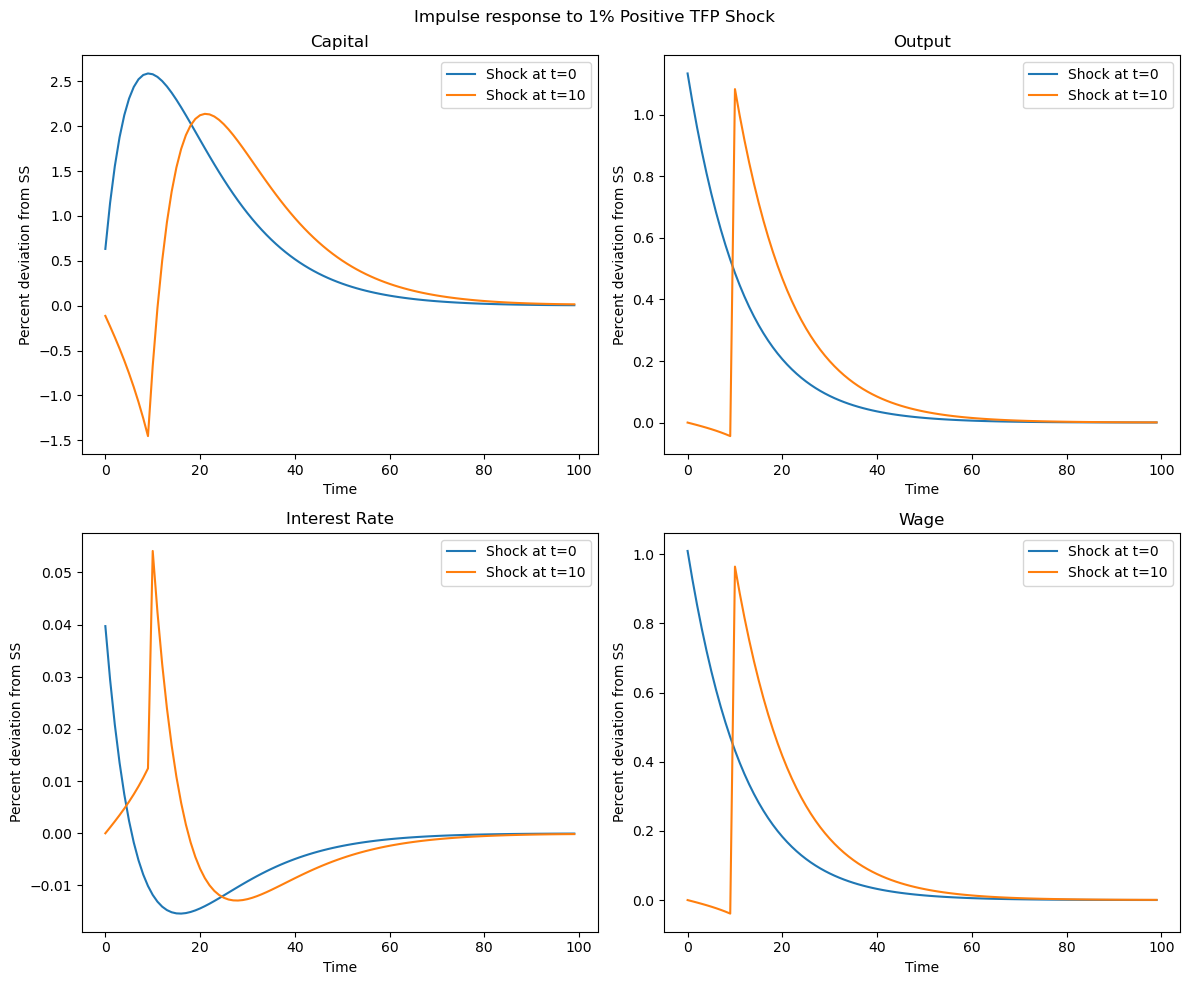

In [12]:
# Plot the impulse response functions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot K
axs[0, 0].plot(K0, label='Shock at t=0')
axs[0, 0].plot(K10, label='Shock at t=10')
axs[0, 0].set_title('Capital')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Percent deviation from SS')
axs[0, 0].legend()

# Plot Y
axs[0, 1].plot(Y0, label='Shock at t=0')
axs[0, 1].plot(Y10, label='Shock at t=10')
axs[0, 1].set_title('Output')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Percent deviation from SS')
axs[0, 1].legend()

# Plot r
axs[1, 0].plot(r0, label='Shock at t=0')
axs[1, 0].plot(r10, label='Shock at t=10')
axs[1, 0].set_title('Interest Rate')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Percent deviation from SS')
axs[1, 0].legend()

# Plot w
axs[1, 1].plot(w0, label='Shock at t=0')
axs[1, 1].plot(w10, label='Shock at t=10')
axs[1, 1].set_title('Wage')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Percent deviation from SS')
axs[1, 1].legend()

# Add a suptitle
fig.suptitle('Impulse response to 1% Positive TFP Shock')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

### 7. Check answers

$$ 
\begin{align*}
[\mathbf{H}_K]_{t,s} &= \frac{\partial \mathbf{A}_t}{\partial r_{s+1}} \frac{\partial r_{s+1}}{\partial K_s} + \frac{\partial \mathbf{A}_t}{\partial w_{s+1}} \frac{\partial w_{s+1}}{\partial K_s} - \mathbb{1}_{\{s=t\}} \\
[\mathbf{H}_Z]_{t,s} &= \frac{\partial \mathbf{A}_t}{\partial r_{s}} \frac{\partial r_{s}}{\partial Z_s} + \frac{\partial\mathbf{A}_t}{\partial w_{s}} \frac{\partial w_{s}}{\partial Z_s}  \\~\\
\end{align*}
$$

where we have: 
$$
\begin{align*}

\frac{\partial r_{s+1}}{\partial K_{s}} &= \alpha (\alpha - 1) Z_{ss} \left( \frac{K_{ss}}{L_{ss}} \right)^{\alpha-2} \frac{1}{L_{ss}} \\
\frac{\partial w_{s+1}}{\partial K_{s}} &= \alpha (1 - \alpha) Z_{ss} \left( \frac{K_{ss}}{L_{ss}} \right)^{\alpha-1} \frac{1}{L_{ss}} \\
\frac{\partial r_{s}}{\partial Z_s} &= \alpha \left( \frac{K^{ss}}{L^{ss}} \right)^{\alpha-1} \\
\frac{\partial w_{s}}{\partial Z_s} &= (1-\alpha) \left( \frac{K^{ss}}{L^{ss}} \right)^{\alpha}
\end{align*}
$$

d:\Anaconda\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format


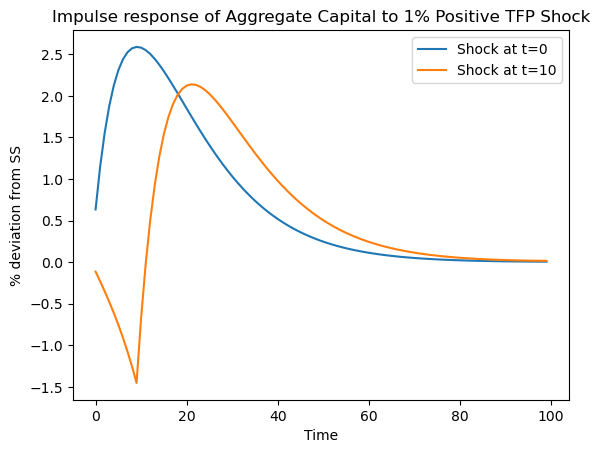

In [13]:
drleaddK = ( alpha * (alpha-1) * ss['Z'] * (ss['K'] / ss['L'])**(alpha-2) * (1/ss['L']) ) * np.hstack((np.ones((T,T-1)) , np.zeros((T,1))))
dwleaddK = ( alpha * (1-alpha) * ss['Z'] * (ss['K'] / ss['L'])**(alpha-1) * (1/ss['L']) ) * np.hstack((np.ones((T,T-1)) , np.zeros((T,1))))
drdZ = alpha * (ss['K']/ss['L'])**(alpha-1) * I
dwdZ = (1-alpha) * (ss['K']/ss['L'])**(alpha) * I

J_Arlead = np.hstack((J_HA['A']['r'][:, 1:] , np.zeros((T,1))))
J_Awlead = np.hstack((J_HA['A']['w'][:, 1:] , np.zeros((T,1))))

dHdK = J_Arlead * drleaddK + J_Awlead * dwleaddK - I
dHdZ = J_HA['A']['r']*drdZ + J_HA['A']['w']*dwdZ
dKdZ = -sp.sparse.linalg.spsolve(dHdK, dHdZ)

# AR(1) shock at t=0 and t=10
rho = 0.9

z0 = np.zeros(T)
z10 = np.zeros(T)

z0[0] = 1
z10[10] = 1

for i in range(1, T):
    z0[i] = rho * z0[i-1] 

for i in range(11, T): 
    z10[i] = rho * z10[i-1]


K0 = dKdZ @ z0 
K10 = dKdZ @ z10 

# Plot k and z 
plt.plot(K0, label='Shock at t=0')
plt.plot(K10, label='Shock at t=10')
plt.xlabel('Time')
plt.ylabel('% deviation from SS')
plt.title('Impulse response of Aggregate Capital to 1% Positive TFP Shock')
plt.legend()
plt.show()